In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from gym.envs.toy_text import discrete
import time
import timeit
import random
import seaborn as sns
from matplotlib.patches import Arrow
import multiprocessing

import qiskit
from qiskit.aqua.input import LinearSystemInput
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms.classical import ExactLSsolver
from qiskit import BasicAer, QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.single_sample import HHL
from qiskit import IBMQ

In [2]:
# Parameters
tam = 4
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
HOLES = {5, 7, 11, 13}
GOAL = {15}
SLP = 0

IBMQ.load_accounts()

In [3]:
# Environment
class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.
    For example, a 4x4 grid looks as follows:
    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T
    x is your position and T are the two terminal states.
    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4, 4]):
        
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape) # number of states
        nA = 4              # number of actions
        slp = 100 - SLP     # 1 - percentage of sleepiness

        self.MAX_Y = shape[0]    # shape of the gridworld, x direction
        self.MAX_X = shape[1]    # shape of the gridworld, y direction

        P = {}              # dictionary of [states] [actions] = ([1.0, next_state, reward, is_done])
        self.grid = np.zeros(shape) - 1.0
        it = np.nditer(self.grid, flags=['multi_index']) # iteration over array 'grid'
        
        '''
        Numeration of the matrix 4x4 is as follows:
        0 1 2 3
        4 5 6 7
        8 9 10 11
        12 23 14 15
        '''

        while not it.finished:
            s = it.iterindex                    # states
            y, x = it.multi_index

            if s == (nS - 1):
                self.grid[y][x] = 0.0

            P[s] = {a : [] for a in range(nA)}  # dictionary with info of state, action and reward

            is_done = lambda s: s in GOAL #can be modified to include more goals
            is_dead = lambda s: s in HOLES #can be modified to include more holes
            reward = 1.0 if is_done(s) else -1.0 if is_dead(s) else 0.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            #else:           #One may want to include some kind of list of goal states to substitute the next four lines.
            ns_up = s if y == 0 else s - self.MAX_X # move one full row to the left
            ns_right = s if x == (self.MAX_X - 1) else s + 1
            ns_down = s if y == (self.MAX_Y - 1) else s + self.MAX_X # move one full row to the right
            ns_left = s if x == 0 else s - 1
            
            def rand_choice(orig):
                r = random.randint(0,3)
                if r == 0:
                    return ns_up
                elif r == 1:
                    return ns_right
                elif r == 2:
                    return ns_down
                elif r == 3:
                    return ns_left
                else:
                    return orig
            
            P[s][UP] = [(1.0, ns_up if random.randint(0,100) < slp else rand_choice(ns_up), reward, False)]
            P[s][RIGHT] = [(1.0, ns_right if random.randint(0,100) < slp else rand_choice(ns_right), reward, False)]
            P[s][DOWN] = [(1.0, ns_down if random.randint(0,100) < slp else rand_choice(ns_down), reward, False)]
            P[s][LEFT] = [(1.0, ns_left if random.randint(0,100) < slp else rand_choice(ns_left), reward, False)]


            it.iternext()

        # Initial state distribution is uniform
        isd = np.zeros(nS)
        isd[0] = 1
        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        self.grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(self.grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()

    def gen_features(self, state):

        y, x = np.unravel_index(state, self.shape)

        features = [np.linalg.norm([np.array((x, y)) - (0, 0)]),
                    np.linalg.norm((np.array((x, y)) - np.array((self.MAX_X, self.MAX_Y))))]
        return features

In [4]:
# Quantum Utilities
def build_circuit(matrix, vector_u, vector_p):
    n_io = int(np.log2(np.size(vector_u)))
    # vector_p /= np.linalg.norm(vector_p)
    # Parameters for HHL algorithm
    num_ancillae = 3
    num_time_slices = 50
    params = dict()
    params['problem'] = {
        'name': 'linear_system'
    }
    params['backend'] = {
        'provider': 'qiskit.BasicAer',
        'name': 'statevector_simulator'
    }
    params['algorithm'] = {
        'truncate_powerdim': False,
        'truncate_hermitian': False
    }
    params['reciprocal'] = {
        'name': 'Lookup',
        'negative_evals': True
    }
    params['eigs'] = {
        'expansion_mode': 'suzuki',
        'expansion_order': 2,
        'name': 'EigsQPE',
        'negative_evals': True,
        'num_ancillae': num_ancillae,
        'num_time_slices': num_time_slices
    }
    params['initial_state'] = {
        'name': 'CUSTOM'
    }
    params['iqft'] = {
        'name': 'STANDARD'
    }
    params['qft'] = {
        'name': 'STANDARD'
    }
    algo_input = LinearSystemInput(matrix=matrix, vector=vector_u)
    hhl = HHL.init_params(params, algo_input)
    # Quantum circuit for HHL
    qc = hhl.construct_circuit()
    # HHL solution output register and success bit register
    io = hhl._io_register
    anc1 = hhl._ancilla_register
    # Quantum registers for Swap test
    psas = QuantumRegister(n_io, 'psas')
    anc2 = QuantumRegister(1, 'anc2')
    c1 = ClassicalRegister(1, 'c1')
    c2 = ClassicalRegister(1, 'c2')
    # Add registers to quantum circuit
    qc.add_register(psas, anc2, c1, c2)
    # Initialize vector_p on psas register
    qc.initialize(vector_p, psas)
    # exit(0)
    # Swap test: control swap for dot product
    qc.h(anc2)
    for i in range(n_io):
        qc.cswap(anc2, psas[i], io[i])
    qc.h(anc2)
    # Projection and meassurement
    qc.barrier(anc1)
    qc.barrier(anc2)
    qc.measure(anc1, c1)
    qc.measure(anc2, c2)
    return qc

def quantum_solver(matrix, vector_u, vector_p):
    assert np.abs(np.linalg.norm(vector_u))-1<1e-10 # assert vector_u is normalized
    assert np.abs(np.linalg.norm(vector_p))-1<1e-10 # assert vector_p is normalized
    kappa = np.linalg.cond(matrix)
    shots = 8192
    qc = build_circuit(matrix, vector_u, vector_p)

    backend_qasm = BasicAer.get_backend('qasm_simulator')
    job_qasm = execute(qc, backend_qasm, shots=shots)
    result_qasm = job_qasm.result()
    counts = result_qasm.get_counts(qc)

    # backend_state=BasicAer.get_backend('statevector_simulator')
    # job_state=execute(qc,backend_state)
    # result_state=job_state.result()
    # outputstate=result_state.get_statevector(qc,decimals=3)
    # print(outputstate)
    # import pdb; pdb.set_trace()
    # return

    error = 0
    success = 0
    for key, value in counts.items():
        k = key.split()
        if int(k[1]) == 0:
            error += value
        elif int(k[0]) == 0:
            success += value
    # prob1 = 1 - error/shots # Success probability in HHL anc1
    prob2 = 1 - success/(shots-error) # Probability of failure of anc2
    if prob2 > 0.5: prob2 = .5
    dot_product = np.sqrt(1-2*prob2) #*np.linalg.norm(vector_p) # kappa*np.sqrt(prob1)
    return dot_product, counts

def classical_solver(matrix, vector_u, vector_p):
    A_inv = np.linalg.inv(np.matrix(matrix))
    # vector_u /= np.linalg.norm(vector_u)
    # vector_p /= np.linalg.norm(vector_p)
    x = A_inv*np.matrix(vector_u).T
    x /= np.linalg.norm(x)
    kappa = np.linalg.cond(matrix)
    dot_product = x.T*np.matrix(vector_p).T
    return dot_product, x, kappa

In [5]:
# Utilities
def trans_mat(env):
    return (np.array([[np.eye(1, env.nS, env.P[s][a][0][1])[0] for a in range(env.nA)] for s in range(env.nS)]),
            np.array([env.P[s][0][0][2] for s in range(env.nS)]))

def expected_utility(a, s, U, trans_probs):
    """The expected utility of doing a in state s, according to the MDP and U."""
    return sum([p * U[s1] for s1, p in enumerate(trans_probs[s, a, :])])

In [6]:
# Policy Iteration
def parllel(tup):
    i = tup[0]
    j = tup[1]
    tam = tup[2]
    R = tup[3]
    M = tup[4]
    trans_probs = tup[5]
    gamma = tup[6]
    U = tup[7]
    
    if j == 0 and i >= tam:
        r = R[i-tam]
    elif j == 1 and (i+1)%tam != 0:
        r = R[i+1]
    elif j == 2 and i+tam < tam*tam:
        r = R[i+tam]
    elif j == 3 and i%tam != 0:
        r = R[i-1]
    else:
        r = R[i]

    pa = gamma*np.dot(trans_probs[i,j],U)
    #product, _, _ = quantum_solver(M, -R, trans_probs[i,j])
    #pa = gamma*product
    par = r + pa
    
    return (i,par,j)
        
def policy_iteration(trans_probs, reward, tam, grid, im, ax, fig, gamma=0.9, epsilon=1e-3):
    pool = multiprocessing.Pool()
    n_states, n_actions, _ = trans_probs.shape
    PI1 = [0 for s in range(n_states)]
    PIs = []
    R = reward
    deltas = []
    delta = 10000
    k = 0
    while delta >= epsilon:
        PI = PI1.copy()
        PIs.append(PI)
        delta = 0
        P = np.zeros((n_states, n_states))
        for i in range(n_states):
            P[i] = trans_probs[i,PI[i]]
        M = (gamma*P)-np.eye(n_states)
        U = np.dot(np.linalg.inv(M),(-R))
        
        # paralellise
        data = []
        for i in range(n_states):
            for j in range(n_actions):
                data.append((i, j, tam, R, M, trans_probs, gamma, U))
        
        aux = list(pool.map(parllel, data))
        lista = [[] for i in range(n_states)]
        for tup in aux:
            lista[tup[0]].append((tup[1], tup[2]))
        for i in range(n_states):
            mayor = max(lista[i],key=lambda x: x[0])
            PI1[i] = mayor[1]
        
        delta = max(abs(np.subtract(PI1, PI)))
        deltas.append(delta)
        k = k+1
        draw_policies(U, PI1, grid, im, k, ax, fig)
        
    return PI1, deltas, U, PIs

In [7]:
# Print utilities
def to_mat(u, shape):
    dst = np.zeros(shape)
    for k in range(len(u)):
        dst[k // shape[1], k % shape[1]] = u[k]
    return dst

def add_arrow(pi, shape):
    a = []
    for k in range(len(pi)):
        if pi[k] == UP:
            a.append(plt.arrow(k % shape[1], k // shape[1], 0, -0.45, head_width=0.05))
        elif pi[k] == RIGHT:
            a.append(plt.arrow(k % shape[1], k // shape[1], 0.45, 0, head_width=0.05))
        elif pi[k] == DOWN:
            a.append(plt.arrow(k % shape[1], k // shape[1], 0, 0.45, head_width=0.05))
        elif pi[k] == LEFT:
            a.append(plt.arrow(k % shape[1], k // shape[1], -0.45, 0, head_width=0.05))
    return a

def start_draw_policies(U, PI, grid, ax, fig):
    plt.clf()
    im = plt.imshow(to_mat(U, grid.shape), cmap="summer")
    add_arrow(PI, grid.shape)
    ax.set_title("Iter " + str(0))
    fig.canvas.draw()
    plt.pause(.1)
    return im
    
def draw_policies(U, PI, grid, im, ite, ax, fig):
    plt.clf()
    im = plt.imshow(to_mat(U, grid.shape), cmap="summer")
    add_arrow(PI, grid.shape)
    ax.set_title("Iter " + str(ite))
    fig.canvas.draw()
    plt.pause(.1)
    return im

def text_render(pos, is_done, is_dead, tam):
    string = ""
    for i in range(tam*tam):
        if i%tam == 0:
            print(string)
            print("------------------")
            string = "|"
        if i == pos:
            string = string + "S|"
        elif is_done(i):
            string = string + "G|"
        elif is_dead(i):
            string = string + "H|"
        else:
            string = string + "F|"
    print(string)
    print("------------------")
    
def start_render(pos, is_done, is_dead, tam, ite, ax):
    m = np.zeros((tam,tam))
    for i in range(tam):
        for j in range(tam):
            if is_dead(i*tam+j):
                m[i,j] = -10
            elif i*tam+j == pos:
                m[i,j] = 10
            elif is_done(i*tam+j):
                m[i,j] = 5
            else:
                m[i,j] = 0
    im = ax.imshow(m,cmap="viridis")
    return im
    
def render(pos, is_done, is_dead, tam, ite, im):
    m = np.zeros((tam,tam))
    for i in range(tam):
        for j in range(tam):
            if is_dead(i*tam+j):
                m[i,j] = -10
            elif i*tam+j == pos:
                m[i,j] = 10
            elif is_done(i*tam+j):
                m[i,j] = 5
            else:
                m[i,j] = 0
    im.set_data(m)

<IPython.core.display.Javascript object>


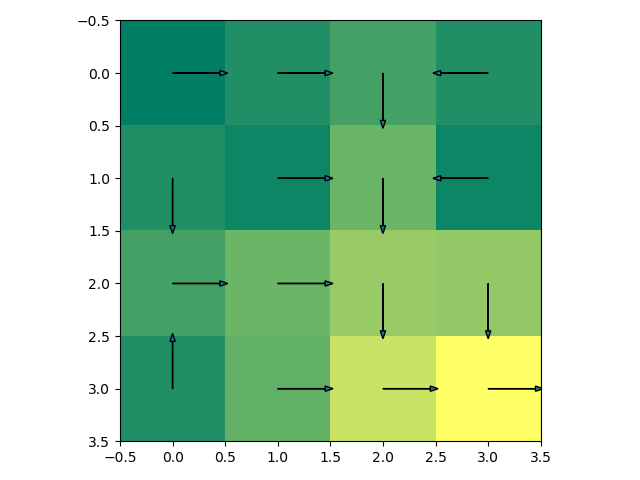

[ 5.31441  5.9049   6.561    5.9049   5.9049   5.561    7.29     5.561
  6.561    7.29     8.1      8.       5.9049   7.1      9.      10.     ]
[1, 1, 2, 3, 2, 1, 2, 3, 1, 1, 2, 2, 0, 1, 1, 1]
0.9173548329999903


In [12]:
%matplotlib nbagg
# Policy Iteration
if __name__ == '__main__':
    grid = GridworldEnv(shape=(tam,tam))
    trans_probs, reward = trans_mat(grid)
    
    fig, ax = plt.subplots()
    ax.axis('off')
    fig.tight_layout()
    im = start_draw_policies([0 for s in range(tam*tam)], [0 for s in range(tam*tam)], grid, ax, fig)
    
    start_time = timeit.default_timer()
    PI, deltas, U, PIs = policy_iteration(trans_probs, reward, tam, grid, im, ax, fig)
    elapsed = timeit.default_timer() - start_time
    print(U)
    print(PI)
    print(elapsed)

    start_draw_policies(U, PI, grid, ax, fig)

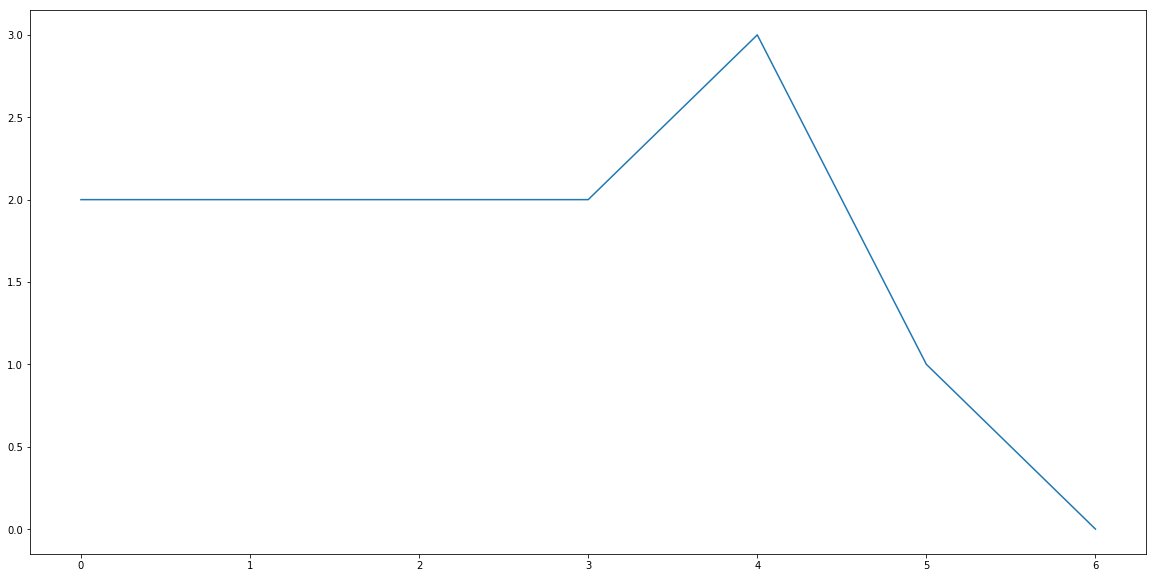

In [13]:
%matplotlib inline
# Show error reduction
plt.figure(figsize=(20, 10))
plt.plot(deltas)

<IPython.core.display.Javascript object>


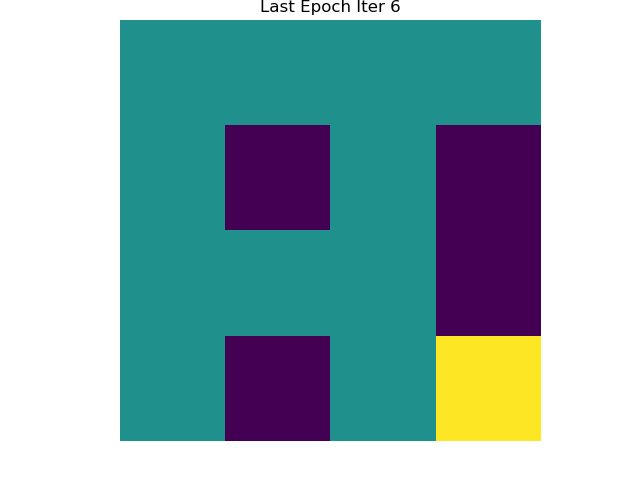

In [14]:
%matplotlib nbagg
done = False
is_done = lambda s: s in GOAL #can be modified to include more goals
is_dead = lambda s: s in HOLES #can be modified to include more holes
pos = 0
ite = 1

fig, ax = plt.subplots()
ax.axis('off')
fig.tight_layout()

for i in range(len(PIs)):
    pos = 0
    ite = 1
    done = False
    im = start_render(pos, is_done, is_dead, tam, 0, ax)
    ax.set_title("Epoch " + str(i) + " Iter " + str(0))
    fig.canvas.draw()
    plt.pause(1)
    while not done:
        pos1 = pos
        if PIs[i][pos] == 0 and pos >= tam:
            pos = pos-tam
        elif PIs[i][pos] == 1 and (pos+1)%tam != 0:
            pos = pos+1
        elif PIs[i][pos] == 2 and pos+tam < tam*tam:
            pos = pos+tam
        elif PIs[i][pos] == 3 and pos%tam != 0:
            pos = pos-1
        render(pos, is_done, is_dead, tam, ite, im)
        ax.set_title("Epoch " + str(i) + " Iter " + str(ite))
        fig.canvas.draw()
        plt.pause(.1)
        ite = ite + 1
        done = is_done(pos) or is_dead(pos) or pos == pos1
        
pos = 0
ite = 1
done = False
im = start_render(pos, is_done, is_dead, tam, 0, ax)
ax.set_title("Last Epoch Iter " + str(0))
fig.canvas.draw()
plt.pause(1)
while not done:
    pos1 = pos
    if PI[pos] == 0 and pos >= tam:
        pos = pos-tam
    elif PI[pos] == 1 and (pos+1)%tam != 0:
        pos = pos+1
    elif PI[pos] == 2 and pos+tam < tam*tam:
        pos = pos+tam
    elif PI[pos] == 3 and pos%tam != 0:
        pos = pos-1
    render(pos, is_done, is_dead, tam, ite, im)
    ax.set_title("Last Epoch Iter " + str(ite))
    fig.canvas.draw()
    plt.pause(.1)
    ite = ite + 1
    done = is_done(pos) or is_dead(pos) or pos == pos1